In [ ]:
#Import Packages

#Model
import keras
from keras import Sequential
from keras.layers import *
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/thesis_files


In [ ]:
#Hyper-params
MAX_LENGTH = 290

user_tag = "<USER/>"
no_hashtags_tag = "<NO TAGS/>"
other_emoji_tag = "<OTHER_EMOJI/>"
emoji_tag = "<EMOJI/>"
new_line_tag = "\n"
char_dict = {}


dataset = "large"   #"large" or "small"
topic_dataset = False   #"True" to select topic dataset 
topic = "blm"   # or "covid" or "brexit"
save_model = False
train_model = False   #True to train model here



In [ ]:
def split(word):
    #splits string into array of characters
    return [char for char in word] 


def get_char_dict():
  #creates a dictionary of characters and assigns a unique numerical index to
  #each
  #leaves index 0 empty to be used for padding

  chars = string.digits
  chars += string.ascii_lowercase
  chars += " "
  chars += string.punctuation
  chars += '’'
  chars += '‘'
  chars = split(chars)
  #add freq emoji unicode to arr
  #for i in get_freq_emojis():
  #  chars.append(i)
  #add tag for other emoji to arr
  #chars.append(other_emoji_tag)
  chars.append(emoji_tag)
  chars.append(user_tag)
  #chars.append(new_line_tag)
  
  for i in range(len(chars)):
    char_dict[chars[i]] = i+1

  return char_dict

  

def get_vocab_size():
  #returns integer containing size of the character dictionary

  return len(set(char_dict))
      

get_char_dict() # generate the character dictionary

{' ': 37,
 '!': 38,
 '"': 39,
 '#': 40,
 '$': 41,
 '%': 42,
 '&': 43,
 "'": 44,
 '(': 45,
 ')': 46,
 '*': 47,
 '+': 48,
 ',': 49,
 '-': 50,
 '.': 51,
 '/': 52,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10,
 ':': 53,
 ';': 54,
 '<': 55,
 '<EMOJI/>': 72,
 '<USER/>': 73,
 '=': 56,
 '>': 57,
 '?': 58,
 '@': 59,
 '[': 60,
 '\\': 61,
 ']': 62,
 '^': 63,
 '_': 64,
 '`': 65,
 'a': 11,
 'b': 12,
 'c': 13,
 'd': 14,
 'e': 15,
 'f': 16,
 'g': 17,
 'h': 18,
 'i': 19,
 'j': 20,
 'k': 21,
 'l': 22,
 'm': 23,
 'n': 24,
 'o': 25,
 'p': 26,
 'q': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'x': 34,
 'y': 35,
 'z': 36,
 '{': 66,
 '|': 67,
 '}': 68,
 '~': 69,
 '‘': 71,
 '’': 70}

In [ ]:
#Load data

#Change directory to location of the preprocessed data
%cd preprocessed_data/


if topic_dataset == True:
  if  topic == "brexit":
    x = np.load("x_brexit.npy")
    y = np.load("y_brexit.npy")

  if topic == "covid":
    x = np.load("x_covid.npy")
    y = np.load("y_covid.npy")

  if topic == "blm":
    x = np.load("x_blm.npy")
    y = np.load("y_blm.npy")

  print(len(x), len(y))

elif dataset == "large":
  x_train = np.load("x_train_large.npy")
  y_train = np.load("y_train_large.npy")
  x_test = np.load("x_test_large.npy")
  y_test = np.load("y_test_large.npy")
  
  print(len(x_train), len(y_train))




/content/drive/My Drive/thesis_files/preprocessed_data
201750 201750


In [ ]:
# Define Tweet2Vec model

vocab_size = get_vocab_size() +1
labels_size = y_train[0].size
encoding_size = 350
embedding_size = vocab_size 

if train_model == True:



  model = Sequential(name = "Tweet2Vec")

  model.add(Embedding(input_dim = vocab_size, input_length = MAX_LENGTH, output_dim= embedding_size, name = "Embedding"))
  model.add(Bidirectional(GRU(encoding_size, return_sequences= False), name = "Bi-GRU", merge_mode='sum'))

  model.add(Dense(labels_size, activation="softmax", name = "Output", kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)))


  model.compile(loss='categorical_crossentropy',
                    optimizer='RMSProp',
                    metrics=['accuracy'])

else:
  #change directory to location of pre-saved model
  %cd ..
  %cd Model/
  
  print("Using pretrained model")
  model = keras.models.load_model('Tweet2Vec.h5')

model.summary()

/content/drive/My Drive/thesis_files
/content/drive/My Drive/thesis_files/Model
Using pretrained model
Model: "Tweet2Vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 290, 74)           5476      
_________________________________________________________________
Bi-GRU (Bidirectional)       (None, 350)               894600    
_________________________________________________________________
Output (Dense)               (None, 3)                 1053      
Total params: 901,129
Trainable params: 901,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train model

if train_model == True:
  def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr/10

  callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

  history = model.fit(x_train, y_train, epochs = 15,
                      batch_size= 64, validation_split = 0.1, callbacks=[callback])



In [ ]:
# Test Model

y_numerical = [] 

#covert categorical --> numerical labels
for i in y_test:
  y_numerical.append(np.argmax(i))


y_pred = model.predict(x_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


accuracy = accuracy_score(y_numerical, y_pred_bool)

print(classification_report(y_numerical, y_pred_bool))
print(accuracy)



1577/1577 [==============================] - 21s 13ms/step
              precision    recall  f1-score   support

           0       0.63      0.59      0.61     14953
           1       0.61      0.63      0.62     17855
           2       0.65      0.66      0.65     17630

    accuracy                           0.63     50438
   macro avg       0.63      0.63      0.63     50438
weighted avg       0.63      0.63      0.63     50438

0.6277806415797613


Normalized confusion matrix
[[0.59 0.23 0.18]
 [0.17 0.63 0.2 ]
 [0.13 0.22 0.66]]


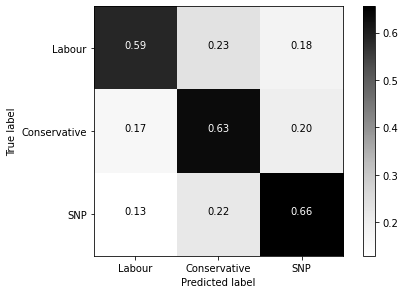

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

#Error analysis
cm = confusion_matrix(y_numerical, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    
    #prints and plots the confusion matrix
    #Normalization can be applied by setting normalize=  "True"
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_numerical, y_pred_bool)
np.set_printoptions(precision=2)


#plot CM
plt.figure()
plot_confusion_matrix(cm, classes=["Labour", "Conservative", "SNP"],
                      title='')
plt.show()







In [ ]:

if train_model == True:
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [ ]:
#Save model
if save_model == True:
  %cd Model/
  path = "Model/" 
  model.save('Tweet2Vec.h5')

[Errno 2] No such file or directory: '/content/drive/My Drive/thesis_files/model'
/content/drive/My Drive/thesis_files/Model


In [ ]:
#create new model: "model2" to output embeddings rather than class predictions


gru = model.get_layer("Bi-GRU")
#transfer embeddings weights into new model
embeddings_test = gru.get_weights()[1]


model2 = Sequential()

model2.add(Embedding(input_dim = vocab_size, input_length = MAX_LENGTH, output_dim= embedding_size, name = "Embedding"))
model2.add(Bidirectional(GRU(encoding_size, return_sequences=False), name = "Bi-GRU", merge_mode='sum', weights = gru.get_weights()))


model2.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])


print(model2.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 290, 74)           5476      
_________________________________________________________________
Bi-GRU (Bidirectional)       (None, 350)               894600    
Total params: 900,076
Trainable params: 900,076
Non-trainable params: 0
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>


In [ ]:
#Generate embeddings for unseen data


if topic_dataset == False:
  embeddings1 = model2.predict(x_test[:25000])
  embeddings2 = model2.predict(x_test[25000:])
  embeddings = np.concatenate((embeddings1, embeddings2))

else:

  embeddings = model2.predict(x)
  embeddings = np.asarray(embeddings)




In [ ]:
print(embeddings.shape)
print(y.shape)


(3479, 350)
(3479, 3)


In [ ]:
#Save embeddings
%cd ..
%cd Embeddings/

if topic_dataset == False:      
  np.save("x_embeddings.npy", embeddings)
  np.save("y_embeddings.npy", y)

else:
  if topic == "Brexit":
    np.save("brexit_x_embeddings.npy", embeddings)
    np.save("brexit_y_embeddings.npy", y)
  
  if topic == "blm":
    np.save("blm_x_embeddings.npy", embeddings)
    np.save("blm_y_embeddings.npy", y)

  if topic == "covid":
    np.save("covid_x_embeddings.npy", embeddings)
    np.save("covid_y_embeddings.npy", y)


print("Embeddings Saved.")
!ls